# 🥱 LangGraph_Agentic RAG 篇

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).


# 環境建置

## 安裝套件包

在深入 RAG 機制之前，我們需要先搭建實驗環境。以下是所需的套件安裝命令：

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community
%pip install --upgrade --quiet langchain-openai
%pip install --upgrade --quiet tiktoken
%pip install --upgrade --quiet langchainhub
%pip install --upgrade --quiet chromadb
%pip install --upgrade --quiet langchain
%pip install --upgrade --quiet langgraph
%pip install --upgrade --quiet langchain-text-splitters

我們需要設置 環境變數 OPENAI_API_KEY ，可以直接完成，如下所示：

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

> 📌 實用提示：確保所有環境變數都正確設置，這對於順利運行後續程式碼至關重要。

### (可用可不用)LangSmith

你用LangChain構建的許多應用程式將包含多個步驟，並多次調用LLM調用。隨著這些應用程式變得越來越複雜，能夠檢查您的鏈或代理內部到底發生了什麼變得至關重要。最好的方法是與[LangSmith](https://smith.langchain.com)合作。

請注意，LangSmith 不是必需的，但它很有説明。如果您確實想使用 LangSmith，請在上面的鏈接中註冊后，請確保設置環境變數以開始記錄跟蹤：

In [ ]:
import os
import getpass
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %Z")

os.environ["LANGCHAIN_TRACING_V2"] = "false" ##想要使用記得改 true, 不要時改 false.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph Agentic RAG-{current_time}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## 建立檢索器(Retriever)

首先讀取三篇部落格文章，建立索引，並且存入到 Chroma 向量資料庫中

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

接著來建立 Tool，等等要提供給 Agent 做使用

In [ ]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

## 描述整體 Graph 狀態


我們將定義一個圖結構。

`state` 物件會在圖中的每個節點之間傳遞。

我們的 `state` 將會是一個 `messages` 的列表。

圖中的每個節點都會將內容附加到該列表中。

In [ ]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

## 建立節點函數與邊

我們可以如下方式構建一個 Agentic RAG 圖：

* `state` 是一組訊息的集合
* 每個節點都會更新（附加）`state`
* 條件邊決定下一個要訪問的節點

![流程圖](https://i.imgur.com/PnshbIH.png)

### Import Wall

In [ ]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition


### 建立邊

在 LangGraph 的工作流程中，conditional edges 扮演著決策點的角色，決定下一步操作的走向。這個函式專門用於評估檢索文件的相關性，進而引導工作流程的分支選擇。

在 LangGraph 的上下文中，`grade_documents` 函式的主要任務是：
1. 接收當前狀態（包含用戶查詢和檢索到的文件）。
2. 使用進階的語言模型（如 GPT-4）評估文件與查詢的相關性。
3. 基於評估結果，返回一個決策 —— "generate" 或 "rewrite"。

這個決策直接影響工作流程的下一步：如果文件被判定為相關（返回 "generate"），工作流程會進入生成答案的階段；如果不相關（返回 "rewrite"），則可能轉向重新檢索文件或重新制定查詢策略。

In [ ]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    判斷檢索到的文件是否與問題相關。

    參數:
        state (messages): 當前狀態

    返回:
        str: 文件是否相關的決定，"generate" 或 "rewrite"
    """

    print("---CHECK RELEVANCE---")

    # 定義數據模型
    class grade(BaseModel):
        """用於相關性檢查的二元評分。"""

        binary_score: str = Field(description="相關性評分，'yes' 或 'no'")

    # 初始化 LLM 模型
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # 將 LLM 與工具和驗證結合
    llm_with_tool = model.with_structured_output(grade)

    # 定義提示模板
    prompt = PromptTemplate(
        template="""您是一位評估檢索文件與用戶問題相關性的評分員。\n
        以下是檢索到的文件：\n\n {context} \n\n
        以下是用戶問題：{question} \n
        如果文件包含與用戶問題相關的關鍵詞或語義，請將其評為相關。\n
        給出二元評分 'yes' 或 'no' 以表示文件是否與問題相關。""",
        input_variables=["context", "question"],
    )

    # 創建鏈
    chain = prompt | llm_with_tool

    # 從狀態中提取消息
    messages = state["messages"]
    last_message = messages[-1]

    # 提取問題和文件
    question = messages[0].content
    docs = last_message.content

    # 調用鏈進行評分
    scored_result = chain.invoke({"question": question, "context": docs})

    # 獲取評分結果
    score = scored_result.binary_score

    # 根據評分結果返回決策
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

### 建立節點

下面定義了 LangGraph 框架中的三個關鍵節點函數：agent、rewrite 和 generate。這些函數共同構成了一個複雜的問答系統工作流程。讓我們深入了解每個函數的作用及其在整個系統中的重要性：

1. agent 函數：
這是工作流程的起點。它使用 GPT-4 模型來理解用戶的初始查詢，並決定下一步操作。這個函數的關鍵在於它能夠綁定外部工具（如檢索工具），使模型能夠根據需要獲取額外信息。
2. rewrite 函數：
當初始查詢不夠清晰或需要優化時，這個函數會被調用。它利用 GPT-4 模型來重新表述問題，使其更加明確和有針對性。這一步驟對於提高最終答案的質量至關重要。
3. generate 函數：
這是最終的答案生成階段。它使用檢索增強生成（RAG）技術，結合了從外部源檢索到的文檔和用戶的問題，然後使用 GPT-3.5-turbo 模型生成最終答案。這個函數集成了提示工程、語言模型和後處理步驟，以產生高質量的回應。

### 回答問題用 Agent

In [ ]:
def agent(state):
    """
    調用代理模型根據當前狀態生成回應。根據問題決定是否使用檢索工具或直接結束。

    參數:
        state (messages): 當前狀態

    返回:
        dict: 更新後的狀態，包含添加到消息列表中的代理回應
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

### 重寫文案用 節點

In [ ]:
def rewrite(state):
    """
    轉換查詢以產生更好的問題。

    參數:
        state (messages): 當前狀態

    返回:
        dict: 更新後的狀態，包含重新表述的問題
    """
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    查看輸入並嘗試推理潛在的語義意圖/含義。 \n
    這是初始問題: \n
------- \n
    {question} \n
------- \n
    制定一個改進的問題: """,
        )
    ]

    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}

### 生成最後答案節點

In [ ]:
prompt = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question}
    Context: {context}
    Answer:
    """

def generate(state):
    """
    生成答案

    參數:
        state (messages): 當前狀態

    返回:
         dict: 更新後的狀態，包含生成的答案
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    #
    prompt = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question}
    Context: {context}
    Answer:
    """

    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = PromptTemplate.from_template(prompt) | llm | StrOutputParser()
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

print("*" * 20 + "Default RAG Prompt" + "*" * 20)
print(prompt)

********************Default RAG Prompt********************

    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question}
    Context: {context}
    Answer:
    


### 編譯圖：LangGraph 工作流程結構解析

1. **工作流程初始化**：
   程式首先創建了一個 `StateGraph` 對象，這是整個工作流程的骨架。`AgentState` 參數定義了圖中流動的狀態類型。

2. **節點定義**：
   工作流程中定義了四個主要節點：
   - `agent`：負責理解查詢並做出決策。
   - `retrieve`：使用 `ToolNode` 封裝檢索工具，用於獲取相關文檔。
   - `rewrite`：用於重新表述問題，提高查詢質量。
   - `generate`：在確認文檔相關性後生成最終回答。

3. **起始邊緣**：
   工作流程從 `START` 開始，直接連接到 `agent` 節點，這是每次查詢的入口點。

4. **條件邊緣**：
   - 從 `agent` 節點出發，根據 `tools_condition` 的評估結果決定下一步：
     - 如果需要使用工具，流程轉向 `retrieve` 節點。
     - 否則，流程直接結束（END）。
   - 從 `retrieve` 節點出發，使用 `grade_documents` 函數評估檢索到的文檔相關性。

5. **結束邊緣**：
   - `generate` 節點直接連接到 END，表示答案生成後工作流程結束。
   - `rewrite` 節點連接回 `agent`，允許在需要時重新開始流程。

6. **圖形編譯**：
   最後，調用 `compile()` 方法將定義的工作流程轉換為可執行的圖形。

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

retrieve = ToolNode([retriever_tool])

# 定義新的圖形
workflow = StateGraph(AgentState)

# 定義我們將在其間循環的節點
workflow.add_node("agent", agent)  # 代理節點
workflow.add_node("retrieve", retrieve)  # 檢索節點
workflow.add_node("rewrite", rewrite)  # 重寫問題節點
workflow.add_node(
    "generate", generate
)  # 生成回應節點（在確認文件相關性後使用）

# 呼叫代理節點來決定是否進行檢索
workflow.add_edge(START, "agent")

# 決定是否檢索
workflow.add_conditional_edges(
    "agent",
    # 評估代理決策
    tools_condition,
    {
        # 將條件輸出轉換為圖中的節點
        "tools": "retrieve",
        END: END,
    },
)

# 在 `retrieve` 節點被呼叫後的邊緣
workflow.add_conditional_edges(
    "retrieve",
    # 評估文件相關性
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 編譯圖形
graph = workflow.compile()

### 視覺化查看圖

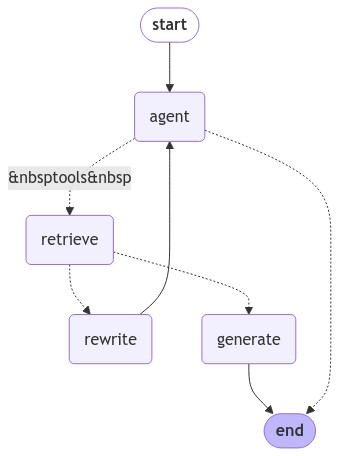

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 與圖互動

In [ ]:
import pprint

inputs = {
    "messages": [
        ("user", "Lilian Weng 如何介紹 agent memory?"),
    ]
}
for event in graph.stream(inputs, stream_mode="values"):
  for message in event["messages"]:
        message.pretty_print()

================================ Human Message =================================

Lilian Weng 如何介紹 agent memory?
---CALL AGENT---
================================ Human Message =================================

Lilian Weng 如何介紹 agent memory?
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_Q4FdDldyNtD8cgMBPR4WXjvA)
 Call ID: call_Q4FdDldyNtD8cgMBPR4WXjvA
  Args:
    query: agent memory
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
================================ Human Message =================================

Lilian Weng 如何介紹 agent memory?
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_Q4FdDldyNtD8cgMBPR4WXjvA)
 Call ID: call_Q4FdDldyNtD8cgMBPR4WXjvA
  Args:
    query: agent memory
================================= Tool Message =================================
Name: retrieve_blog_posts

The design of generative agents combine